# Introduction to Natural Language Processing 2 Lab03

## Introduction

On this part, we will evaluate a simple semantic search with and without nearest neighbours approximation. We fill first create a searchable index, then evaluate queries on it in terms of Mean Average Precision and speed.

### Create a searchable index

In [1]:
%pip install beir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 19.6 MB/s eta 0:00:00
  Created wheel for beir: filename=beir-1.0.1-py3-none-any.whl size=62516 sha256=7391bb5c00e68f631a5738931b0b8d9783da7e05ab2cbe0d76a3f14bb8338900
  Stored in directory: /root/.cache/pip/wheels/49/e8/58/18d0218f6a1eb9b343b100181915dccc668d7fe688704be89c
  Created wheel for pytrec_eval: filename=pytrec_eval-0.5-cp37-cp37m-linux_x86_64.whl size=301783 sha256=2cbab760438bd92979080f8b21228fadf7482dde04b844c5defe0083dc9ffb6f
  Stored in directory: /root/.cache/pip/wheels/42/96/77/0829b8b2606f90f61ba10a51277629d2b615604e122ee932f4
  Created wheel f

In [2]:
import numpy as np
import time
import random
import pandas as pd

In [3]:
# Use the Beir library to extract the test set of the DBPedia entity dataset.

from beir import util
from beir.datasets.data_loader import GenericDataLoader

def extract_test(dataset):
    """
    Extract the test test set with the Beir library.
        Parameters:
            dataset (str): name of the dataset
        Returns:
        corpus, queries, qrels (dicts): The test set
    """
    url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
    data_path = util.download_and_unzip(url, "datasets")
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
    return corpus, queries, qrels

dataset = "dbpedia-entity"
corpus, queries, qrels = extract_test(dataset)

/opt/conda/lib/python3.7/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


datasets/dbpedia-entity.zip:   0%|          | 0.00/610M [00:00<?, ?iB/s]

  0%|          | 0/4635922 [00:00<?, ?it/s]

What are the three values returned by Beir, and how are they presented ?

...

*Let's see what the first values of each value look like*

In [4]:
list(queries.items())[:10]

[('INEX_LD-2009022', 'Szechwan dish food cuisine'),
 ('INEX_LD-2009039', 'roman architecture'),
 ('INEX_LD-2009053', 'finland car industry manufacturer saab sisu'),
 ('INEX_LD-2009061', 'france second world war normandy'),
 ('INEX_LD-2009062', 'social network group selection'),
 ('INEX_LD-2009063', 'D-Day normandy invasion'),
 ('INEX_LD-2009074', 'web ranking scoring algorithm'),
 ('INEX_LD-2009115', 'virtual museums'),
 ('INEX_LD-2010004', 'Indian food'),
 ('INEX_LD-2010014', 'composer museum')]

In [5]:
print("Number of queries:", len(queries))

Number of queries: 400


In [6]:
print("Number of corpus:", len(corpus))
list(corpus.items())[:5]

Number of corpus: 4635922


[('<dbpedia:Animalia_(book)>',
  {'text': "Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over three million copies have been sold.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.",
   'title': 'Animalia (book)'}),
 ('<dbpedia:Academy_Award_for_Best_Production_Design>',
  {'text': "The Academy Awards are the oldest awards ceremony for achievements in motion pictures. The Academy Award for Best Production Design recognizes achievement in art direction on a film. The category's original name was Best Art Direction, but was changed to its current name in 2012 for the 85th Academy Awards.  This change resulted from the Art Director's branch of the Academy being renamed the Designer's branch.",
   'title': 'Academy Award for Best Production Design'}),
 ('<dbpedia:An_American_in_Paris>',
  {'tex

In [7]:
qrels['INEX_LD-2009022']

{'<dbpedia:Afghan_cuisine>': 0,
 '<dbpedia:Akan_cuisine>': 0,
 '<dbpedia:Ambuyat>': 0,
 '<dbpedia:American_Chinese_cuisine>': 1,
 '<dbpedia:Ants_climbing_a_tree>': 2,
 '<dbpedia:Baingan_bharta>': 1,
 '<dbpedia:Bamischijf>': 0,
 '<dbpedia:Black_cardamom>': 0,
 '<dbpedia:Brazilian_cuisine>': 0,
 '<dbpedia:British_cuisine>': 0,
 '<dbpedia:Caribbean_cuisine>': 0,
 '<dbpedia:Cellophane_noodles>': 1,
 '<dbpedia:Ceviche>': 0,
 '<dbpedia:Chana_masala>': 0,
 '<dbpedia:Chen_Kenichi>': 1,
 '<dbpedia:Chen_Kenmin>': 1,
 '<dbpedia:Chicago-style_pizza>': 0,
 '<dbpedia:Chicken_(food)>': 0,
 '<dbpedia:Chifle>': 0,
 '<dbpedia:Chili_oil>': 2,
 '<dbpedia:Chinatown,_Los_Angeles>': 0,
 '<dbpedia:Chinatown>': 1,
 '<dbpedia:Chinese_cuisine>': 2,
 '<dbpedia:Churumuri_(food)>': 0,
 '<dbpedia:Cookbook>': 0,
 '<dbpedia:Cooking>': 0,
 '<dbpedia:Couscous>': 0,
 '<dbpedia:Cuban_cuisine>': 0,
 '<dbpedia:Cuisine>': 0,
 '<dbpedia:Cuisine_of_Jharkhand>': 0,
 '<dbpedia:Cuisine_of_the_Southern_United_States>': 0,
 '<dbped

To ease the problem, extract all the document from the corpus which are relevant to at least one query. Then, add 100K random documents which are not relevant to any query. Make sure the process is reproducible by setting the random seed on whatever random sampling method you use.

In [8]:
corpus_reduced_dict = {}
qrels_irrelevant = []

# Get all the corpus that are relevant to queries
for id, query in queries.items():
    # Get al the relevant content with the id of the query
    qrels_for_id = qrels[id]

    # Get all the queries that are relevant (value 1 or 2)
    qrels_relevant = []
    for id, relevancy in qrels_for_id.items():
        if relevancy > 0:
            qrels_relevant.append(id)
    
    # Get the corpus elements corresponding and add them the the reduced corpus
    for id in qrels_relevant:
        corpus_reduced_dict[id] = corpus[id]

corpus_irrelevant = {}
for id, corp in corpus.items():
    if id not in corpus_reduced_dict:
        corpus_irrelevant[id] = corp

corpus_reduced = list(corpus_reduced_dict.values())

# Choose the 100k random documents
random.seed(42)
corpus_random_keys = random.sample(list(corpus_irrelevant), 100000)

for id in corpus_random_keys:
    corpus_reduced.append(corpus[id])
    corpus_reduced_dict[id] = corpus[id]

print("Total length of the documents chosen:", len(corpus_reduced))


Total length of the documents chosen: 114877


Now, we should be ready to start experimenting with our smaller dataset. Use the
sentence-transformers library to index your dataset. As queries and documents
are different, use an asymetric similarity models. Pick one model across the
ones proposed. Make sure to document your choice, and why you picked it (because
of accuracy, speed, ...).

**Response:**
On the documentation for asymetric similarity models, we can choose from
multiple models. Ones being for cosine-similarity and the others being tuned for
dot-product. The two models in each categorie having the best accuracies are:
- msmarco-distilbert-base-v4 (for cosine-similarity).
- msmarco-distilbert-base-tas-b (for dot-product).

Here we have short passages, and no very long paragraph. As recommended in the
docummentation we are going to use the dot model.

In [9]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('msmarco-distilbert-base-tas-b')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Embed the reduced corpus and the queries using the chosen model.

In [10]:
# Encode the corpus
corpus_embeddings = model.encode(corpus_reduced, show_progress_bar=True, normalize_embeddings=True)

Batches:   0%|          | 0/3590 [00:00<?, ?it/s]

In [11]:
# Encode the queries
queries_embeddings = model.encode(list(queries.values()), show_progress_bar=True, normalize_embeddings=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [12]:
print("Corpus embeddings:\n", corpus_embeddings)
print("Queries embeddings:\n", queries_embeddings)

Corpus embeddings:
 [[-0.01574451  0.00755481 -0.00977126 ...  0.01982185  0.01842164
  -0.003728  ]
 [-0.00526378  0.03504581 -0.01447122 ...  0.03222863  0.009765
   0.01768871]
 [-0.02864997 -0.00071679  0.0042687  ...  0.00381516  0.00689341
  -0.04419584]
 ...
 [-0.00157355  0.01447236  0.00181427 ...  0.00996679 -0.03956143
   0.02850429]
 [-0.04041721 -0.0045453   0.02482732 ... -0.00896117 -0.02426492
  -0.01452521]
 [-0.02210536  0.03162534 -0.00218727 ...  0.00680959 -0.00261384
   0.01642023]]
Queries embeddings:
 [[ 0.01273451  0.00926685  0.00078944 ...  0.00171824  0.00395796
  -0.01994021]
 [ 0.0176757   0.03175262  0.00826586 ... -0.01855571 -0.03254419
   0.00382852]
 [ 0.01210523  0.00428768  0.00128748 ... -0.02177536 -0.01737421
  -0.02737603]
 ...
 [-0.02529463 -0.00727855  0.02930842 ... -0.02321853  0.00115842
   0.00779354]
 [-0.00716714  0.01388094  0.0045116  ...  0.00384754  0.04274917
  -0.01549987]
 [ 0.02388808  0.01915977  0.00160654 ... -0.02157108  0.01

In [13]:
from sentence_transformers import util as st_util

# Compute the semantic_search
hits = st_util.semantic_search(queries_embeddings, corpus_embeddings, top_k = 100, score_function=st_util.dot_score, corpus_chunk_size=10000)
hits[0]

[{'corpus_id': 26, 'score': 0.8736340403556824},
 {'corpus_id': 554, 'score': 0.8186438083648682},
 {'corpus_id': 20, 'score': 0.818345308303833},
 {'corpus_id': 544, 'score': 0.8120450377464294},
 {'corpus_id': 12, 'score': 0.8087615370750427},
 {'corpus_id': 81485, 'score': 0.806640625},
 {'corpus_id': 0, 'score': 0.8043345212936401},
 {'corpus_id': 18, 'score': 0.8026472926139832},
 {'corpus_id': 24, 'score': 0.8021990656852722},
 {'corpus_id': 8, 'score': 0.8020032048225403},
 {'corpus_id': 531, 'score': 0.8009045720100403},
 {'corpus_id': 525, 'score': 0.8008530735969543},
 {'corpus_id': 1239, 'score': 0.8006097078323364},
 {'corpus_id': 14, 'score': 0.7997300028800964},
 {'corpus_id': 533, 'score': 0.7989543676376343},
 {'corpus_id': 59373, 'score': 0.7984433770179749},
 {'corpus_id': 99752, 'score': 0.7977863550186157},
 {'corpus_id': 57248, 'score': 0.7977515459060669},
 {'corpus_id': 88902, 'score': 0.7970752716064453},
 {'corpus_id': 494, 'score': 0.7967804074287415},
 {'corp

Using the annotated set of queries, compute the Mean Average Precision (MAP) @100 as well as the average time per query.

The problem with the results we have is that we only get a `corpus_id`. We need to transform the `corpus_id` to the matching corpus key to be able to compute the confusion matrix.

In [15]:
hits_corpus = []
list_corpus_reduced = list(corpus_reduced_dict.items())

idx = 0
for result in hits:
    dict_corpus_key = {}
    for item in result:
        # Retrieve the corpus key with the corpus_id and the list of corpus_reduced
        corpus_key = list_corpus_reduced[item['corpus_id']][0]
        dict_corpus_key[corpus_key] = item['score']
    hits_corpus.append(dict_corpus_key)
    idx +=1

print("Corpus keys with score values:\n")
hits_corpus[0]

Corpus keys with score values:



{'<dbpedia:Sichuan_cuisine>': 0.8736340403556824,
 '<dbpedia:Manchow_soup>': 0.8186438083648682,
 '<dbpedia:List_of_Chinese_dishes>': 0.818345308303833,
 '<dbpedia:List_of_Indian_dishes>': 0.8120450377464294,
 '<dbpedia:Guizhou_cuisine>': 0.8087615370750427,
 '<dbpedia:Meze>': 0.806640625,
 '<dbpedia:American_Chinese_cuisine>': 0.8043345212936401,
 '<dbpedia:Indian_Chinese_cuisine>': 0.8026472926139832,
 '<dbpedia:Shuizhu>': 0.8021990656852722,
 '<dbpedia:Chinese_cuisine>': 0.8020032048225403,
 '<dbpedia:Indian_Singaporean_cuisine>': 0.8009045720100403,
 '<dbpedia:Gujarati_cuisine>': 0.8008530735969543,
 '<dbpedia:List_of_Vietnamese_dishes>': 0.8006097078323364,
 '<dbpedia:History_of_Chinese_cuisine>': 0.7997300028800964,
 '<dbpedia:Indian_cuisine>': 0.7989543676376343,
 '<dbpedia:List_of_foods_of_the_Southern_United_States>': 0.7984433770179749,
 '<dbpedia:Quyrdak>': 0.7977863550186157,
 '<dbpedia:Szászvár>': 0.7977515459060669,
 '<dbpedia:Cuisine_of_Gower>': 0.7970752716064453,
 '<db

In [16]:
# Transform the qrels into a list to have only the information about the relevency
list_qrels = list(qrels.values())

In [19]:
def average_precision_k(hit_score : dict, qrel_query : list):
    """
    Returns the average precision for each query
        Parameters:
            hit_score (dict): dict of corpus_key and score matching the analyzed query
            qrel_query (list): list of information for the relevant corpus for the analyzed query
        Returns:
            (float): AP@K for the specified query
    """
    # Filter the qrel_query to only have the relevant responses
    qrel_query =  {key:val for key, val in qrel_query.items() if val > 0}
    keys_query = set(hit_score.keys())
    keys_qrel_query = set(qrel_query.keys())

    # Check which hit is relevant
    relevant_hit = keys_query.intersection(keys_qrel_query)
  
    precision_k = [0 for _ in range(100)]
    list_hit_corpus = list(hit_score.keys())
    nb_of_relevant = 0
    for i in range(1, 100):
        # Check if the content is relevant, if it is we set the value
        # else we let it at 0 
        if list_hit_corpus[i - 1] in relevant_hit:
            nb_of_relevant += 1
            precision_k[i - 1] = nb_of_relevant / i

    return sum(precision_k) / len(keys_qrel_query)

a_precision_k_0 = average_precision_k(hits_corpus[0], list_qrels[0])
print("The AP@K of the first query is:\n", a_precision_k_0)

The AP@K of the first query is:
 0.18899296195509976


In [20]:
def mean_average_precision_k(hits_corpus : list, list_qrels : list):
    """
    Computes the Mean Average Prevision K
        Parameters:
            hit_corpus (list): dict of corpus_key and score matching the analyzed query
            qrel_query (list): list of information for the relevant corpus for the analyzed query
        Returns:
            (float): float corresponding to the MAP@K for all the queries
    """
    # Compute the AP@K for all the queries
    a_precision_k = 0
    for i in range(len(hits_corpus)):
        a_precision_k += average_precision_k(hits_corpus[i], list_qrels[i])

  # Compute the MAP@K
    return a_precision_k / len(hits_corpus)

print("The MAP@100 is:", mean_average_precision_k(hits_corpus, list_qrels))

The MAP@100 is: 0.5387619170931068


Let's compute the average time per query

In [21]:
t_start = time.time()
queries_embeddings = model.encode(list(queries.values()), show_progress_bar=True, normalize_embeddings=True)
t_query = time.time() - t_start
hits_time = st_util.semantic_search(queries_embeddings, corpus_embeddings, top_k = 100, score_function=st_util.dot_score, query_chunk_size=1)

t_end = time.time() - t_start
print("The average time per query is :", t_end  / len(queries))

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

The average time per query is : 0.034814553260803224


# Approximate nearest neighbours

Find a good set of parameters for the chosen ANN library and compute the Mean Average Precision @100.

**Response**: We chose to use the Faiss library for the next part.

In [22]:
import faiss

def createIndexFaiss(corpus_embeddings: np.ndarray, top_k_hits : int = 100, n_clusters : int = 800, nprobe : int = 256):
    """
    Creates the index for the ANN
        Parameters:
            corpus_embeddings (numpy.ndarray): matrix of encoded corpus
            top_k_hits (int): int corresponding to the K value
            n_clusters (int): int corresponding to the number of clusters being used by the index
            nprobe (int): int corresponding to the number of buckets
        Returns:
            index(faiss.swigfaiss.IndexIVFFlat): Index used to search in            
    """
    embedding_size = len(corpus_embeddings[0])

    quantizer = faiss.IndexFlatIP(embedding_size) 
    index = faiss.IndexIVFFlat(quantizer, embedding_size, n_clusters, faiss.METRIC_INNER_PRODUCT)

    index.nprobe = nprobe
    index.train(corpus_embeddings)
    index.add(corpus_embeddings)
    return index

In [23]:
def getHitsAnn(index, corpus_reduced_dict : dict, queries_embeddings: np.ndarray, t_per_query : float, top_k_hits : int = 100):
    """
    Computes the hits for the index and the given queries
        Parameters:
            index (faiss.swigfaiss.IndexIVFFlat): Index used to search in
            corpus_reduced_dict (dict): dict of reduced corpus
            queries_embeddings(numpy.ndarray): matrix of encoded queries
            t_per_query (float): average time to encode one query
            top_k_hits (int): int corresponding to the K value
        Returns:
            hits_ann (list of dict): result of the search
            (float): average time per query            
    """
    list_corpus_reduced = list(corpus_reduced_dict.items())

    hits_ann = []
    time_query = 0
    for query_e in queries_embeddings:
        query_e = np.expand_dims(query_e, axis=0)
        t_start = time.time()
        score, corpus_id = index.search(query_e, top_k_hits)
        t_end = time.time()
        time_query += t_query + t_end - t_start

        res = {}
  
        for id, sc in zip(corpus_id[0], score[0]):
          res[list_corpus_reduced[id][0]] = sc
        hits_ann.append(res)
    return hits_ann, time_query / len(queries)
index = createIndexFaiss(corpus_embeddings)
hits_ann, time_per_query = getHitsAnn(index, corpus_reduced_dict, queries_embeddings, t_query/len(queries))
print("Results of the first query with ANN:\n", hits_ann[0])

Results of the first query with ANN:
 {'<dbpedia:Sichuan_cuisine>': 0.87363434, '<dbpedia:Manchow_soup>': 0.818644, '<dbpedia:List_of_Chinese_dishes>': 0.8183448, '<dbpedia:List_of_Indian_dishes>': 0.8120451, '<dbpedia:Guizhou_cuisine>': 0.80876106, '<dbpedia:Meze>': 0.80664057, '<dbpedia:American_Chinese_cuisine>': 0.8043344, '<dbpedia:Indian_Chinese_cuisine>': 0.8026473, '<dbpedia:Shuizhu>': 0.8021994, '<dbpedia:Chinese_cuisine>': 0.8020037, '<dbpedia:Indian_Singaporean_cuisine>': 0.8009044, '<dbpedia:Gujarati_cuisine>': 0.8008534, '<dbpedia:List_of_Vietnamese_dishes>': 0.80061007, '<dbpedia:History_of_Chinese_cuisine>': 0.7997305, '<dbpedia:Indian_cuisine>': 0.7989542, '<dbpedia:List_of_foods_of_the_Southern_United_States>': 0.7984434, '<dbpedia:Quyrdak>': 0.7977865, '<dbpedia:Szászvár>': 0.7977518, '<dbpedia:Cuisine_of_Gower>': 0.7970751, '<dbpedia:Biryani>': 0.79678065, '<dbpedia:North_Indian_cuisine>': 0.794754, '<dbpedia:List_of_kosher_restaurants>': 0.7944125, '<dbpedia:Assames

In [24]:
print("The MAP@100 is:", mean_average_precision_k(hits_ann, list_qrels))

The MAP@100 is: 0.5217087751817958


In [25]:
print("Average time per query with ANN:", time_per_query)

Average time per query with ANN: 0.197507866024971


explain what the parameters you picked are, and why you chose them

**Response:** For the values, we tried multiple combinaisons and we choose the best one among all the one we tested:
- for nprobe: it is the number of corpus being processed at the same time so when we augment it the results gets better
- for the quantizer: we needed to read a bit of documentation and found out that the best one here is 

Play with these parameters and plot a speed vs MAP curve.

In [52]:
# Benchmark of the parameters
nprobe_values = [ 3, 10, 64, 128, 256, 512, 1024 ]
n_clusters_values = [ 64, 128, 256, 512, 1024, 1500, 2048 ]

# List of time and map for each nprobe value
nprobe_time = []
nprobe_map = []
for nprobe in nprobe_values:
    index = createIndexFaiss(corpus_embeddings, nprobe=nprobe)
    hits_ann, time_average = getHitsAnn(index, corpus_reduced_dict, queries_embeddings, t_query/len(queries))
    nprobe_time.append(time_average)
    nprobe_map.append(mean_average_precision_k(hits_ann, list_qrels))

# List of time and map for each n_clusters value
n_clusters_map = []
n_clusters_time = []
for n_cluster in n_clusters_values:
    index = createIndexFaiss(corpus_embeddings, n_clusters=n_cluster)
    hits_ann, time_average = getHitsAnn(index, corpus_reduced_dict, queries_embeddings, t_query/len(queries))
    n_clusters_time.append(time_average)
    n_clusters_map.append(mean_average_precision_k(hits_ann, list_qrels))

In [53]:
# Build the data frame with the values computed
df_nprobe = pd.DataFrame(data={'nprobe' : nprobe_values , 'average_time' : nprobe_time, 'map' : nprobe_map})
df_nprobe

,nprobe,average_time,map
0,3,0.177175,0.383777
1,10,0.178339,0.443007
2,64,0.187191,0.513128
3,128,0.197030,0.521709
4,256,0.217126,0.533872
5,512,0.260133,0.538041
6,1024,0.303725,0.538761


In [54]:
# Build the data frame with the values computed
df_n_clusters = pd.DataFrame(data={'n_clusters' : n_clusters_values, 'average_time' : n_clusters_time, 'map' : n_clusters_map})
df_n_clusters

,n_clusters,average_time,map
0,64,0.302114,0.538710
1,128,0.301607,0.538730
2,256,0.238810,0.535710
3,512,0.208817,0.528616
4,1024,0.193936,0.520791
5,1500,0.189854,0.519241
6,2048,0.187177,0.516239


<AxesSubplot:title={'center':'How the number of clusters affect the average time per query'}, xlabel='Number of clusters', ylabel='Average time per query'>

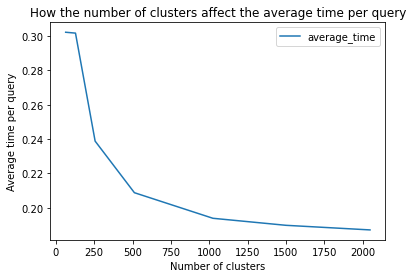

In [55]:
plt = df_n_clusters.plot(x='n_clusters', y='average_time', title='How the number of clusters affect the average time per query')
plt.set_xlabel("Number of clusters")
plt.set_ylabel("Average time per query")
plt

<AxesSubplot:title={'center':'How the number of clusters affect the MAP@100'}, xlabel='Number of clusters', ylabel='MAP@100'>

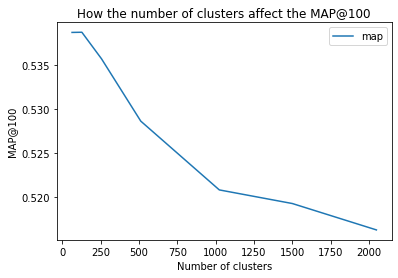

In [56]:
plt = df_n_clusters.plot(x='n_clusters', y='map',  title='How the number of clusters affect the MAP@100')
plt.set_xlabel("Number of clusters")
plt.set_ylabel("MAP@100")
plt

<AxesSubplot:title={'center':'How the number of probe affect the average time per query'}, xlabel='Number of probe', ylabel='Average time per query'>

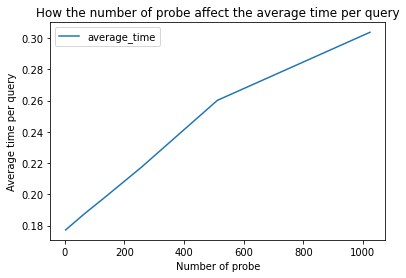

In [57]:
plt = df_nprobe.plot(x='nprobe', y='average_time',  title='How the number of probe affect the average time per query')
plt.set_xlabel("Number of probe")
plt.set_ylabel("Average time per query")
plt

<AxesSubplot:title={'center':'How the number of probe affect the MAP@100'}, xlabel='Number of probe', ylabel='MAP@100'>

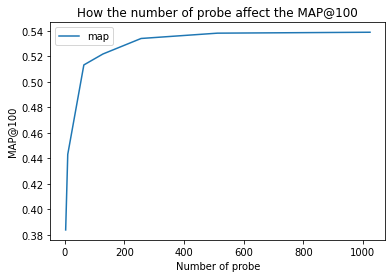

In [58]:
plt = df_nprobe.plot(x='nprobe', y='map',  title='How the number of probe affect the MAP@100')
plt.set_xlabel("Number of probe")
plt.set_ylabel("MAP@100")
plt